In [16]:
import numpy as np
import matplotlib.pyplot as plt

def initial_lattice(N):   
    # generates a random spin configuration for NxN lattice
    return 2*np.random.randint(2, size=(N,N))-1

# Compute energy of the lattice
def Hamiltonian(S, J, B):
    N = len(S[1])
    H = 0
    for i in range(N):
        for j in range(N):
            # Periodic boundary conditions (neighbors: right, down)
            H += -J * S[i][j] * (S[i][(j+1)%N] +  S[(i+1)%N][j]) - B * S[i][j]
    return H


def metropolis_step(S, J, B, beta):
    N = len(S[1])
    for _ in range(N*N): 
        i, j = np.random.randint(0, N), np.random.randint(0, N)
        # TODO: gegebenefalls ohne faktor 2
        dE = J * 2 * S[i][j] * (S[i][(j-1)%N] +  S[(i-1)%N][j] + S[i][(j+1)%N] +  S[(i+1)%N][j])
        if dE < 0 or np.random.rand() < np.exp(-dE * beta):
            S[i, j] *= -1  # Flip spin
    

def Monte_carlo_with_Metropolis_for_2D_Ising(size_lattice, J, B, T, n_thermalization, n_sampling):
    k_B = 1.380649e-23
    beta = 1/(k_B * T) 
    
    N = size_lattice
    S = initial_lattice(N)
    energies, sum_S_list = [], []
    Z = 0
    
    for i in range(n_thermalization):
        metropolis_step(S, J, B, beta)
        
    for i in range(n_sampling):
        metropolis_step(S, J, B, beta)
        E = Hamiltonian(S, J, B)
        energies.append(E)
        sum_S_list.append(np.sum(S))
        Z += np.exp(-E)

    return energies, sum_S_list, Z

def weight_function(energy, Z):
    return np.exp(-energy) / Z 

def magnetization(energies, sum_S_list, Z):
    S = sum_S_list
    M = 0
    for i in range(len(S)):
        M += weight_function(energies[i], Z) * S[i]
    return M

def susceptibility(energies, sum_S_list, Z):
    S = sum_S_list
    M = magnetization(energies, S, Z)
    susc = - M**2
    for i in range(len(S)):
        susc += weight_function(energies[i], Z) * (S[i])**2
    return susc
   
def energy(energies, Z):
    E = 0
    for i in range(len(energies)):
        E += weight_function(energies[i], Z) * energies[i]
    return E  

def specific_heat(energies, sum_S_list, Z):
    S = sum_S_list
    E = energy(energies, Z)
    C_b = - E**2
    for i in range(len(S)):
        C_b += weight_function(energies[i], Z) * (energies[i])**2
    return C_b

# do it several times and average again
def average_MCS(N, number_of_fresh_starts, J, B, T, n_thermalization, n_sampling):
    num = number_of_fresh_starts
    order_average = 0
    susc_average = 0
    spec_heat_average = 0
    for i in range(num):
        energies, sum_S_list, Z = Monte_carlo_with_Metropolis_for_2D_Ising(N, J, B, T, n_thermalization, n_sampling)
        order_average += 1/num * np.abs(magnetization(energies, sum_S_list, Z))
        susc_average += 1/num * susceptibility(energies, sum_S_list, Z)
        spec_heat_average += 1/num * specific_heat(energies, sum_S_list, Z)
    return order_average, susc_average, spec_heat_average



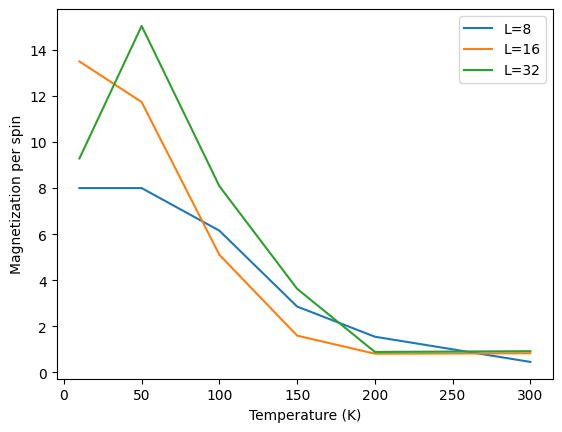

In [23]:
N = np.array([8, 16, 32])
J = 50 * 1.380649e-23
B = 0
T_array = [10, 50, 100, 150, 200, 300]

for n in N:
    order_list, susc_list, spec_heat_list = [], [], []
    for T in T_array:
        order_average, susc_average, spec_heat_average = average_MCS(n, 5, J, B, T, 20, 10) 
        order_list.append(order_average)
        susc_list.append(susc_average)
        spec_heat_list.append(spec_heat_average)
    plt.plot(T_array, order_list/n, label=f'L={n}')

plt.xlabel('Temperature (K)')
plt.ylabel('Magnetization per spin')
plt.legend()
plt.show()